In [ ]:
# Google Drive Connect
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [14]:
# Dataset Zip file Extract
import zipfile
import os

zip_path = "/content/drive/MyDrive/Data.zip"  # Pathway
extract_path = "/content/data"  # Pathway

# Zip file Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")

# Directory Structure
for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    for file in files[:5]:  # Max 5 files
        print(f"  File: {file}")

Dataset extracted to /content/data
Directory: /content/data
Directory: /content/data/Data
Directory: /content/data/Data/train
Directory: /content/data/Data/train/image
  File: 55.png
  File: 11.png
  File: 53.png
  File: 39.png
  File: 48.png
Directory: /content/data/Data/train/mask
  File: 55.png
  File: 11.png
  File: 53.png
  File: 39.png
  File: 48.png
Directory: /content/data/Data/test
Directory: /content/data/Data/test/image
  File: 11.png
  File: 13.png
  File: 12.png
  File: 14.png
  File: 17.png
Directory: /content/data/Data/test/mask
  File: 11.png
  File: 13.png
  File: 12.png
  File: 14.png
  File: 17.png
Directory: /content/data/__MACOSX
  File: ._Data
Directory: /content/data/__MACOSX/Data
  File: ._test
  File: ._train
Directory: /content/data/__MACOSX/Data/train
  File: ._image
  File: ._mask
Directory: /content/data/__MACOSX/Data/train/image
  File: ._13.png
  File: ._9.png
  File: ._74.png
  File: ._43.png
  File: ._42.png
Directory: /content/data/__MACOSX/Data/train/

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Define Dataset Class
class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Load Image & Mask files
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Change Mask into Binary
        mask = (mask > 0).float()  # 0 or 1
        return image, mask

# 데이터 경로 설정
TRAIN_IMAGE_PATH = os.path.join(extract_path, "Data/train/image")
TRAIN_MASK_PATH = os.path.join(extract_path, "Data/train/mask")
TEST_IMAGE_PATH = os.path.join(extract_path, "Data/test/image")
TEST_MASK_PATH = os.path.join(extract_path, "Data/test/mask")

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# 데이터 로더 준비
train_dataset = RetinaDataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, transform=transform)
test_dataset = RetinaDataset(TEST_IMAGE_PATH, TEST_MASK_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [16]:
import torch.nn as nn

class MaskedAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, patch_size=16, image_size=512):
        super(MaskedAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.patch_size = patch_size
        self.image_size = image_size

    def forward(self, x, mask):
        # Mask Dimension Broadcast
        if mask.shape[1] == 1:  # If Mask has Channel Dimension as 1,
            mask = mask.expand(-1, x.size(1), -1, -1)  # expand as big as x's channel size

        # Mask Apply
        x_masked = x * mask
        latent = self.encoder(x_masked)  # Go through Encoder
        reconstructed = self.decoder(latent)  # Go through Decoder
        return reconstructed

# Simply defined Encoder & Decoder
class SimpleEncoder(nn.Module):
    def __init__(self):
        super(SimpleEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

class SimpleDecoder(nn.Module):
    def __init__(self):
        super(SimpleDecoder, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.deconv(x)

In [17]:
import torch.optim as optim

# Reseting Model
encoder = SimpleEncoder()
decoder = SimpleDecoder()
model = MaskedAutoEncoder(encoder, decoder) # Used MAE as encoder/decoder
criterion = nn.MSELoss() #Used MSE Loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Used Adam as an optimizer

# GPU Setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Random Masking
        random_mask = torch.bernoulli(torch.full((images.size(0), 1, images.size(2), images.size(3)), 0.8)).to(device)
        reconstructed = model(images, random_mask)

        # Loss
        loss = criterion(reconstructed * masks, images * masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_loss = 0
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        random_mask = torch.bernoulli(torch.full((images.size(0), 1, images.size(2), images.size(3)), 0.8)).to(device)
        reconstructed = model(images, random_mask)
        loss = criterion(reconstructed * masks, images * masks)
        test_loss += loss.item()

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Epoch [1/100], Loss: 0.0073
Epoch [2/100], Loss: 0.0068
Epoch [3/100], Loss: 0.0060
Epoch [4/100], Loss: 0.0049
Epoch [5/100], Loss: 0.0038
Epoch [6/100], Loss: 0.0030
Epoch [7/100], Loss: 0.0026
Epoch [8/100], Loss: 0.0023
Epoch [9/100], Loss: 0.0021
Epoch [10/100], Loss: 0.0020
Epoch [11/100], Loss: 0.0019
Epoch [12/100], Loss: 0.0019
Epoch [13/100], Loss: 0.0019
Epoch [14/100], Loss: 0.0018
Epoch [15/100], Loss: 0.0018
Epoch [16/100], Loss: 0.0017
Epoch [17/100], Loss: 0.0017
Epoch [18/100], Loss: 0.0016
Epoch [19/100], Loss: 0.0015
Epoch [20/100], Loss: 0.0014
Epoch [21/100], Loss: 0.0013
Epoch [22/100], Loss: 0.0012
Epoch [23/100], Loss: 0.0011
Epoch [24/100], Loss: 0.0010
Epoch [25/100], Loss: 0.0009
Epoch [26/100], Loss: 0.0008
Epoch [27/100], Loss: 0.0007
Epoch [28/100], Loss: 0.0006
Epoch [29/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0005
Epoch [31/100], Loss: 0.0005
Epoch [32/100], Loss: 0.0004
Epoch [33/100], Loss: 0.0004
Epoch [34/100], Loss: 0.0004
Epoch [35/100], Loss: 0

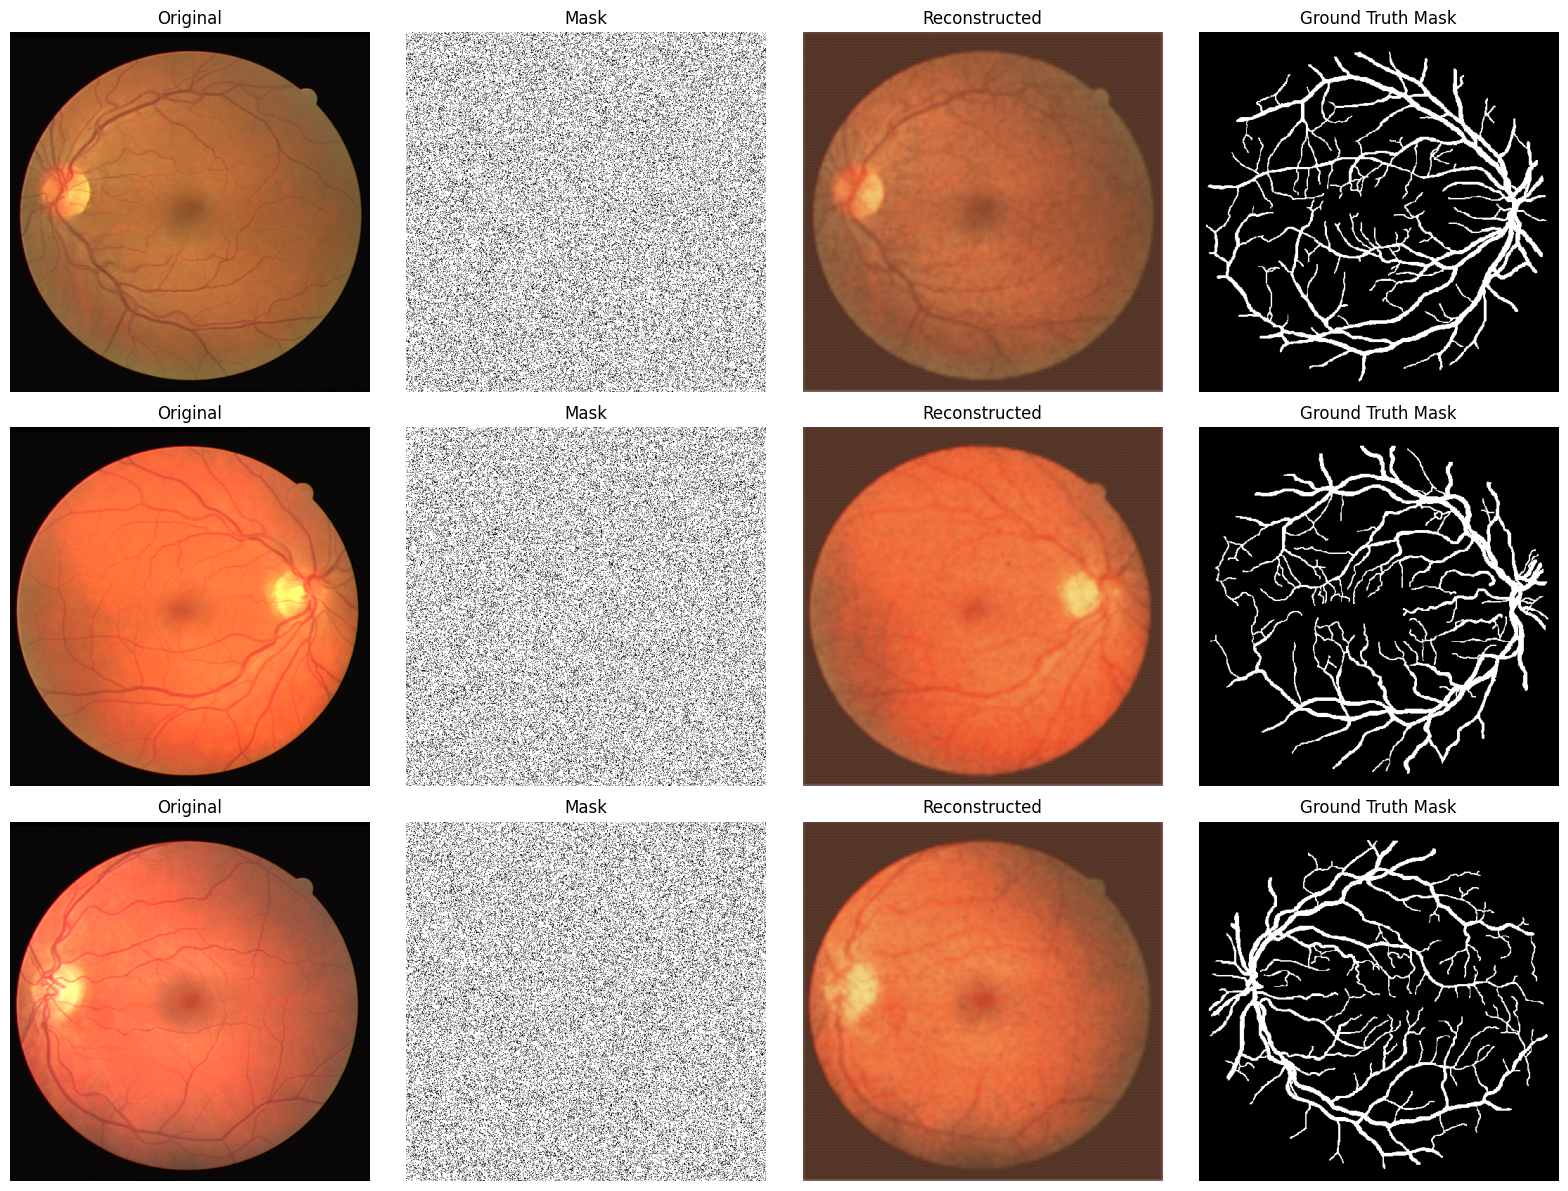

In [18]:
import matplotlib.pyplot as plt

# Result Visualize Function
def visualize_results(original, mask, reconstructed, dataset_mask):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for i in range(3):
        # Original 이미지
        axes[i, 0].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        # Random Mask (1 Channel)
        axes[i, 1].imshow(mask[i].squeeze(0).cpu().numpy(), cmap="gray")
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

        # Reconstructed Image
        axes[i, 2].imshow(reconstructed[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis("off")

        # Dataset Mask (Ground Truth)
        axes[i, 3].imshow(dataset_mask[i].squeeze(0).cpu().numpy(), cmap="gray")
        axes[i, 3].set_title("Ground Truth Mask")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

# Test Data Load
images, dataset_masks = next(iter(test_loader))
images, dataset_masks = images.to(device), masks.to(device)

# Mask & Reconstructed Image
with torch.no_grad():
    random_mask = torch.bernoulli(torch.full((images.size(0), 1, images.size(2), images.size(3)), 0.8)).to(device)
    reconstructed = model(images, random_mask)

# Visualize
visualize_results(images, random_mask, reconstructed, dataset_masks)